In [1]:
# 1. Set-up
# 가장 먼저, 패키지(라이브러리)들을 import 해보겠습니다.
# 우리가 이번 프로젝트에서 사용할 패키지 목록입니다.

import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 앞으로 필요한 변수들을 생성합니다.

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16 # 미니배지로 16개씩 뽑을 거다

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180] # 이미지 크기를 180*180으로 만들거다

# EPOCH 크기 변수
EPOCHS = 25 # 미니배치 16개씩 뽑아서 전체 학습하는 행위를 25번 할거다 

print("ROOT_PATH 는",ROOT_PATH, "입니다.") # 경로 출력

/home/aiffel/aiffel


In [3]:
# 2. 데이터 가져오기

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*')) # train folder 내부 전체 파일
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*')) # test folder 내부 전체 파일
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')) # val folder 내부 전체 파일

print("train folder 내부 전체 파일 개수",len(train_filenames)) # train folder 내부 전체 파일 개수
print("test folder 내부 전체 파일 개수 ",len(test_filenames)) # test folder 내부 전체 파일 개수 
print("val folder 내부 전체 파일 개수",len(val_filenames)) # val folder 내부 전체 파일 개수

5216
624
16


In [4]:
# 갯수 비는 89%, 10.7%, 0.3% 입니다. 
# val 갯수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print("조절한 뒤 train data의 개수 :",len(train_filenames))
print("조절한 뒤 val data의 개수 :",len(val_filenames))

# 이제 train은 4185개, test는 624개, val은 1047개
# test 데이터는 건드리지 않음!!
# 4185 + 1047 = 5216 + 16 (train + validation)

4185
1047


In [5]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 파악 

# 정상 데이터 개수
# train 파일 중에서 NORMAL 이라는 글자가 포함되어 있다면 Count +1
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

# 폐렴 데이터 개수
# train 파일 중에서 PNEUMONIA 이라는 글자가 포함되어 있다면 Count +1
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

# 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. (1106, 3079)
# 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을 수록 training을 잘 합니다. 
# 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다.

# 정확도만 필요하다면 클래스 불균형을 조절할 필요가 없지만, 소수의 집단에 목적이 있는 경우 필요함

Normal images count in training set: 1106
Pneumonia images count in training set: 3079


In [6]:
# tf.data 인스턴스를 만들어 봅시다. 
# tf.data는 tensorflow에서 학습시킬 때, 
# 배치처리 작업을 보다 효율적으로 할 수 있도록 해줍니다.

# 뭔지는 모르겠지만 속도를 높이는 작업이다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
# Train 데이터 셋, validation 데이터 셋 갯수 확인

# Train 데이터 셋 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

# validation 데이터 셋 갯수
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

# 사실 처음에 나눴던 데이터 개수와 차이 없음 
# 다만 tf.data 인스턴스로 변환한 뒤 데이터를 재확인 하는 것

Training images count: 4185
Validating images count: 1047


In [8]:
# 라벨 이름 확인

CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

# 정상을 의미하는 'NORMAL', 폐렴을 의미하는 'PNEUMONIA' 
# 파일 이름을 불러온 뒤, 라벨링에 해당하는 부분만 슬라이싱해서 가져오는 듯 하다.
# .numpy())[2:-1] 이거는 뭔지 모르겠다?!

['PNEUMONIA' 'NORMAL']


In [9]:
# 이름을 라벨 데이터로 만들어주는 함수 설정

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   
# 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.
# 결국 원 핫 인코딩!!이 된다는 의미다

In [10]:
# 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
# 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 
# 이미지 사이즈를 줄여봅시다.

# 이미지 크기를 변환하는 함수
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3) # 채널은 RGB를 말하는 것 같다.
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

In [ ]:
# process_path 함수에서 decode_img 함수를 이용해서 
# 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. 
# get_label을 이용해서 라벨 값을 가져옵니다.

def process_path(file_path):
    label = get_label(file_path) # 라벨을 가져온다. 0과 1의 형태
    img = tf.io.read_file(file_path) # 이미지 불러오기
    img = decode_img(img) # 이미지 리사이즈
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다. 
# num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해줍니다.

# AUTOTUNE = tf.data.experimental.AUTOTUNE
# process_path = 이미지와 라벨값을 리턴하는 함수

# 이러한 함수들을 train data, val data 인스턴스에 적용
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 리사이징과 라벨 확인

# 첫번째 이미지 데이터 리사이징과 라벨값 출력
for image, label in train_ds.take(1): # train_ds.take(1)은 하나의 데이터만 가져온다 라는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test 데이터 셋도 만들기, 데이터 개수 확인

# 테스트 데이터셋에도 위와 동일한 과정을 수행
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.
# 밑에 있는 prepare_for_training() 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.

# shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

# repeat()를 사용하면 epoch를 진행하면서 여러번 데이터셋을 불러오게 되는데, 
# 이때 repeat()를 사용한 데이터셋의 경우 여러번 데이터셋을 사용할 수 있게 해줍니다.
# 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

# batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
# 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

# prefetch()를 사용하면 학습데이터를 나눠서 읽어오기 때문에, 
# 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.


def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 데이터 섞기

    ds = ds.repeat() # 부족했던 부분을 repeat으로 다시 뽑을 수 있게 만들기

    ds = ds.batch(BATCH_SIZE) # 배치 사이즈는 16으로 설정
    
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습데이터를 나눠서 읽어오기

    return ds

train_ds = prepare_for_training(train_ds) # 학습용 훈련데이터로 만들기
val_ds = prepare_for_training(val_ds) # 학습용 훈련데이터로 만들기

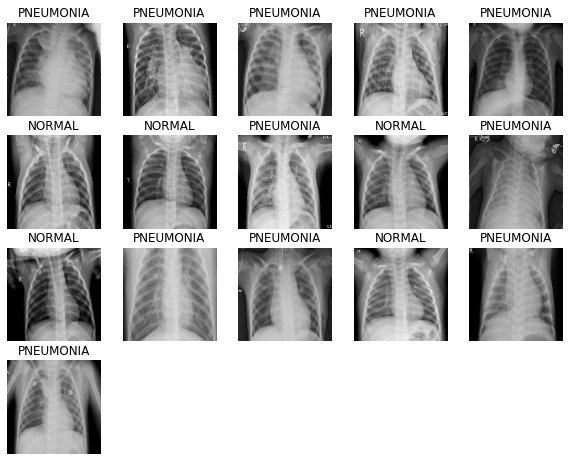

In [15]:
# 3. 데이터 시각화
# 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 
# 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch()함수를 이용해서 결과 사진을 보겠습니다.


# iter는 객체의 __iter__ 메서드를 호출해주고, next는 객체의 __next__ 메서드를 호출해줍니다.
# 근데 무슨 의미인지는 모르겠다.
# 아마도 계속해서 다음 거를 받아오는 듯?!
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16): # 0~15까지
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:# 존재하면? 1이라면 출력해라 라는 의미인가?
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

In [16]:
# 4. CNN 모델링
# 

# Convolution block을 만듭니다. 
# conv_block()의 구성은 Convolution을 두번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 
# 그리고 Max Pooling을 합니다.


# 이미지의 특징을 추출하는 부분
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
# Dense Block 만들기

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
# 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두가지 regularization 기법이 동시에 사용되고 있습니다.
# 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다.
# 그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 
# 예외적으로 동시에 사용하는 것이 성능향상에 도움을 주는 경우가 실제로 있습니다. 
# 두 방법을 같이 쓰는 것을 옹호하는 경우도 있습니다.

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
# 5. 데이터 imbalance 처리

# 위에서 얘기 했던 데이터 imbalance 문제입니다.
# 'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 
# 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습 할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

# 이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. 
# Weight balancing 은 training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. 
# Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.

# 아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0)) # 정상일 경우 가중치
print('Weight for class 1: {:.2f}'.format(weight_for_1)) # 폐렴일 경우 가중치

Weight for class 0: 1.89
Weight for class 1: 0.68


In [20]:
# 6. 모델 훈련
# 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 
# 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

# 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. 
# optimizer로 'adam'을 사용합니다.
# 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
# 모델 훈련

# 모델을 fit 해보겠습니다. 
# 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다.

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 49s 190ms/step - loss: 0.3775 - accuracy: 0.8214 - precision: 0.9487 - recall: 0.8005 - val_loss: 0.6552 - val_accuracy: 0.7673 - val_precision: 0.7673 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 46s 174ms/step - loss: 0.2265 - accuracy: 0.9138 - precision: 0.9692 - recall: 0.9118 - val_loss: 1.3176 - val_accuracy: 0.7673 - val_precision: 0.7673 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 47s 179ms/step - loss: 0.1931 - accuracy: 0.9282 - precision: 0.9737 - recall: 0.9274 - val_loss: 0.9804 - val_accuracy: 0.7712 - val_precision: 0.7712 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 47s 178ms/step - loss: 0.1732 - accuracy: 0.9361 - precision: 0.9763 - recall: 0.9360 - val_loss: 0.0868 - val_accuracy: 0.9615 - val_precision: 0.9577 - val_recall: 0.9937
Epoch 5/25
261/261 [==============================] - 46s 178ms/step - loss: 0.1688 - accura

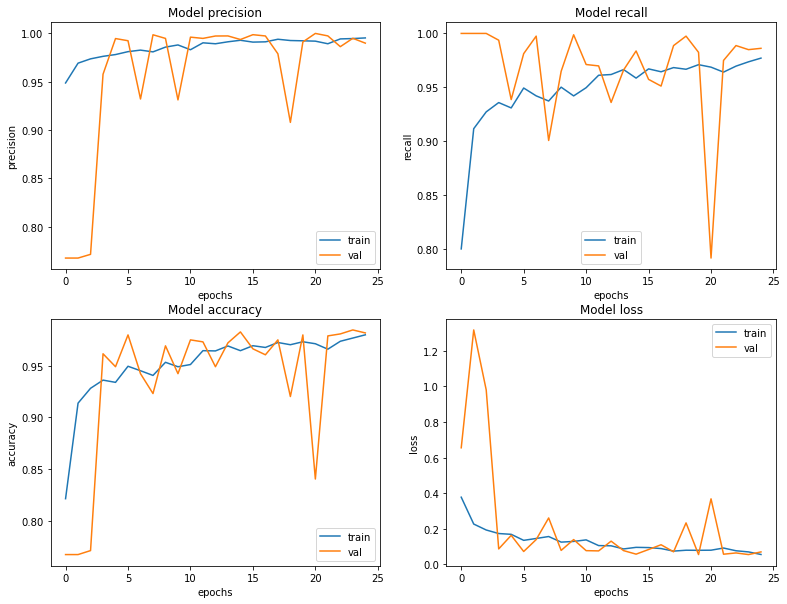

In [32]:
# 7. 결과 확인
# 이제 결과를 확인해보겠습니다. 
# 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

fig, ax = plt.subplots(2, 2, figsize=(13, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
# 테스트 데이터로 모델 평가

loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 5s 119ms/step - loss: 1.0946 - accuracy: 0.8045 - precision: 0.7617 - recall: 1.0000
